# Classifying landcover in wetlands with Sentinel-1 images using machine learning

This notebook serves as a tutorial or reference for the application of unsupervised machine learning techniques for pixel-wise classification of SAR images. Specifically, this notebook demonstrates the application of unsupervised clustering algorithms to the classification of land cover in wetlands - to some extent mimicking the functionality of the Wetlands Insight Tool (WIT), except that the input is Sentinel-1 radar imagery instead of Landsat optical imagery.

Most of the techniques used are not particularly unique to this application, and could be generalised to any problem requiring the use of unsupervised clustering on a per-pixel basis to an xarray object.

In [3]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

import seaborn as sns

## Setting up the datacube interfaces

The Sentinel-1 imagery is stored in its own development datacube for now, rather than the production datacube. An interface to the production datacube is also initialised for comparison of our tools to equivalent optical tools.

In [4]:
dc = datacube.Datacube(config='radar.conf')
dcO = datacube.Datacube()

## Defining region of interest and loading cleaned Sentinel-1 backscatter data

The region we will be using for this application is the Mamukala wetlands, within Kakadu national park. Being a tropical wetland, there is a strong seasonal variation in wetness, resulting in changes in the extent of inundation and photosynthetic vegetation. This makes it an ideal test site to observe relationships between landscape wetness and the Sentinel-1 signal.

The Sentinel-1 scenes in the development datacube have some preprocessing, but have not been filtered to minimise the speckle noise. The `rf.load_cleaned_SAR()` method loads the scenes and applies a spatial Lee filter to smooth the speckling effect. This is important because our final landcover classifications will be per-pixel, so sharp speckling of the image may reduce the quality of the results.

In [5]:
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

allSAR = rf.load_cleaned_SAR(query,dc)

## Preprocessing
Besides the smoothing of the speckle noise, some additional preprocessing is beneficial before applying a clustering algorithm to the dataset:
1. Adding a third component to the dataset, `vh_over_vv`. This is the ratio of the horizontally-polarised (VH) backscatter to the vertical (VV). This is useful for two reasons - firstly, a three-component dataset can be used to produce false-colour images and if the `vh_over_vv` component is used for the blue channel, bodies of water will appear as a bright blue. Secondly, using a ratio of the first two components as the third component will enable the clustering algorithm to effectively produce a nonlinear decision boundary between two clusters in the two-dimensional VH-VV parameter space. This would not otherwise be possible for the simple clustering algorithms we will be using.
2. Taking the logarithm of all the signal components. Using a log-scale enables more sensitive differentiation between two weak signals - 0.01 is much more separate from 0.001 on a log scale than a normal one. Because we want to separately classify at least two flat surfaces (open bodies of water and bare soil), both of which will tend towards specular reflection and thus have low backscatter signals, using a log scale is helpful for our purposes.
3. Normalising the whole timeseries dataset by subtracting the mean and dividing by the standard deviation. I refer to this as 'bulk normalisation' to distinguish it from performing this procedure separately on each scene in the timeseries. Treating the whole timeseries together preserves seasonal variations in the average brightness of the scenes, which will be indicative of large changes in land cover throughout the year. Normalisation in general is important because it enforces the assumption that variation in each component is equally important to classifying the pixel - assuming a clustering algorithm that finds spherical clusters, failing to normalise means that a component with larger variance will be assigned more predictive importance than a component that has smaller variance.

In [6]:
bulknormSAR = rf.bulknorm_SAR_ds(np.log(allSAR))

### Spatial downsampling
The final preprocessing step (used for fitting the models, but not for the prediction input) is downsampling them spatially. This not only enables the fit to complete much faster, but further reduces the effects of the speckle during the fitting stage, reducing the chance of the model fitting to the speckle noise instead of clusters related to land cover. By default each 5x5 pixel area will be sampled as one pixel, but this can be changed with the keyword argument `downsample_factor` on the `rf.downsample_ds()` method.

In [7]:
downsampled = rf.downsample_ds(bulknormSAR)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Simple clustering: KMeans and Gaussian Mixture Models
Scikit-learn includes classes for KMeans clustering and Gaussian mixture models.

A KMeans model attemps to find *k* clusters associated with 'cluster centres', where each sample in the dataset is assigned to the cluster with the closest centre. The mean of all the samples in each cluster should be equal to the cluster centre.

A Gaussian mixture model assumes that each point in the dataset is sampled from one of *k* separate multivariate Gaussian distributions, each with their own means and covariance matrices. The allowance for covariance matrices enables this type of model to fit clusters that are 'non-spherical' in the parameter space.

In theory, the Gaussian mixture could fit well even without normalising our data, but in practice I found this model to perform worse than KMeans and take longer to fit, especially after the data is normalised. Regardless, I have written methods in the module `radar_gmm` (imported as `rg` in this notebook) which enable xarrays to be fit and predicted with both types of model, so you can use either on your data and try it yourself.

In [6]:
#fit the KMeans model
kmeans_model = rg.fit_kmeans(downsampled)

In [7]:
#predict the output cluster labels
kmeans_output = rg.gmm_dataset(bulknormSAR,kmeans_model)

Let's have a look at the raw output from the model at a few times:

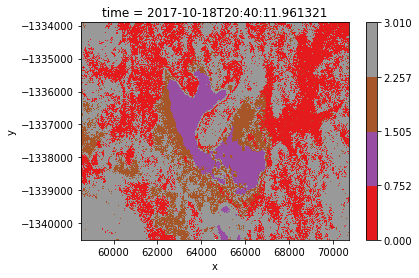

In [29]:
#dry season
kmeans_output.isel(time=57).plot(vmin=0,vmax=3.01,levels=5,cmap='Set1')

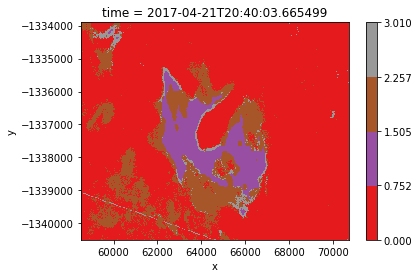

In [36]:
#wet season
kmeans_output.isel(time=35).plot(vmin=0,vmax=3.01,levels=5,cmap='Set1')

The advantage of unsupervised machine learning is that it does not require any human input to find patterns in the input data. The disadvantage is that it has no idea of the meaning of these patterns - in this case, what landcover classes each cluster most closely corresponds to. We must, for now at least, input this information ourselves, although some level of 'dumb' automation is possible here (e.g. hardcoding some likely parameter values for each landcover class and assigning classes to each cluster based on distance from each of these values).

To manually label the resulting images, we can compare to the optical Wetlands Insight Tool at similar time periods. Note that my `wetlands_insight` module actually initialises its own datacube interface so we don't need to pass a handle to the production datacube to load the WIT data.

In [8]:
WIT_images = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 39 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 39 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [12]:
#define a sensible palette to use for the WIT visualisation
pal_opt = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["brown"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"]] 

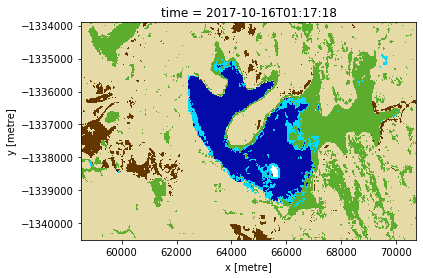

In [48]:
WIT_images.isel(time=14).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False)

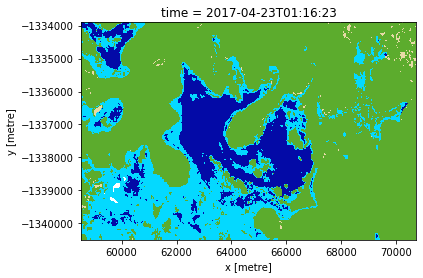

In [47]:
WIT_images.isel(time=5).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False)

We can use this collection of images to determine the mapping between the cluster predictions (0,1,2,3) and landcover classes (open water/dark blue, wet/light blue, photosynthetic vegetation/green, nonphotosynthetic vegetation/beige and bare soil/brown). This will differ between runs of the KMeans algorithm as the initialisation is stochastic (for now). I give an example below - if you have run the code above in this notebook yourself you will need to adjust the mapping for your model.

In [38]:
mapping = [3,0,1,4]
#vectorise the array mapping, handling nans
mapfunc = np.vectorize(lambda i: np.float(mapping.__getitem__(int(i))) if ~np.isnan(i) else i)

mapped_output = xr.apply_ufunc(mapfunc,kmeans_output)

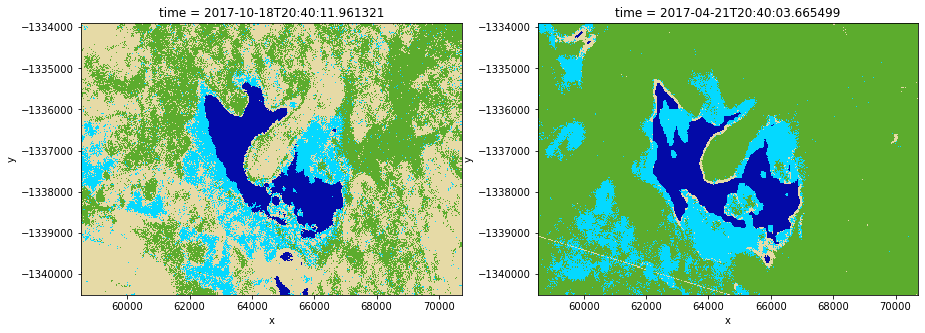

In [44]:
#plot using the same palette as the WIT map
fig,ax = plt.subplots(1,2,figsize=(15,5))
mapped_output.isel(time=57).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,ax=ax[0],add_colorbar=False)
mapped_output.isel(time=35).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,ax=ax[1],add_colorbar=False)

We can now see the water body at the centre of the image, the increased nonphotosynthetic vegetation portion in the dry season and flooding in the wet season, all using an unsupervised clustering algorithm on Sentinel-1 backscatter images, which only contain two components per pixel (even though we did synthesise a third, it is entirely dependent upon the first two so it doesn't really count). This is quite impressive, considering that Landsat images contain many more bands.

However, the clustering algorithm still picks up some bare soil or fire scar areas as 'wet' in these observations. Even adding another class or two to the KMeans clustering does not change this (try it yourself if you like, use the `n_components` kwarg on the `rg.fit_kmeans()` method - the default is 4). To do this we will need a more complex solution.

## Hierarchical clustering: tree of KMeans

Instead of a single KMeans model, we can use a hierarchy of them - data associated with each cluster in the first model is sent to another KMeans model specific to that cluster, and potentially multiple levels of this branching could occur. For our purposes, we will use a 'shallow' tree with only two levels, and three clusters for each of the individual KMeans models, like this:
```
                                KMeans_0
                               /   |   \
                              /    |    \
                             /     |     \
                            /      |      \
                           /       |       \
                      KMeans_1  KMeans_2  KMeans_3
                       / | \     / | \     / | \
                      0  1  2   3  4  5   6  7  8
```

The tree *forces* each cluster to split, regardless of how self-similar or otherwise the data in the cluster is. This means it should be useful for differentiating between landcover classes with similar backscatter signals (e.g. 'wet' and dry bare soil), provided that there is indeed *some* detectable difference between them.

The model is fit recursively - the 'root' KMeans model is fit on the entire training dataset, then the parts of the training dataset assigned to each cluster are sent as the training set to the associated 'branch' model and so on until the 'leaf' model is fit.

This model is implemented in the `rg.SAR_Ktree` class. The number of `levels` in the tree and `branches` (clusters in each individual KMeans model) can be adjusted using keyword arguments if desired.

In [9]:
#initialise the KMeans tree with the default parameters
ktree_model = rg.SAR_Ktree()
#fit this model to the data
ktree_model.fit(downsampled)

In [10]:
ktree_output = ktree_model.predict_dataset(bulknormSAR)

Once again, the model output won't mean much until we label each cluster with a landcover class. We now have more clusters than cover classes, so there will be some repeats.

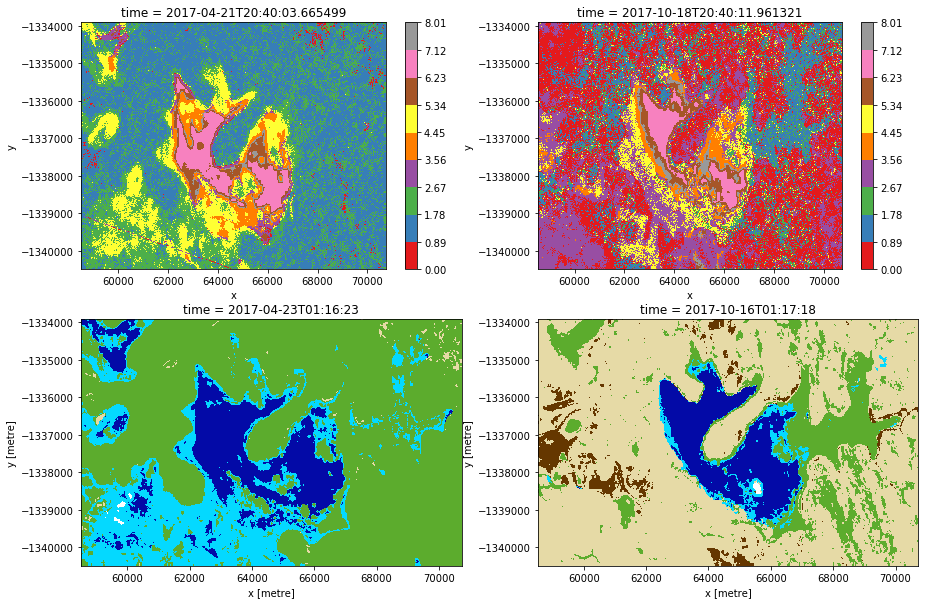

In [13]:
fig,ax=plt.subplots(2,2,figsize=(15,10))
ktree_output.isel(time=35).plot(vmin=0,vmax=8.01,levels=10,cmap='Set1',ax=ax[0,0])
ktree_output.isel(time=57).plot(vmin=0,vmax=8.01,levels=10,cmap='Set1',ax=ax[0,1])
WIT_images.isel(time=5).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[1,0])
WIT_images.isel(time=14).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[1,1])

Note now that we can see some of the fire scars/bare soil as a separate class in the top right image. This means we can make a more effective landcover mapping using the tree model.

In [14]:
mapping = [4,3,3,4,2,1,0,0,1]
#vectorise the array mapping, handling nans
mapfunc = np.vectorize(lambda i: np.float(mapping.__getitem__(int(i))) if ~np.isnan(i) else i)

mapped_output = xr.apply_ufunc(mapfunc,ktree_output)

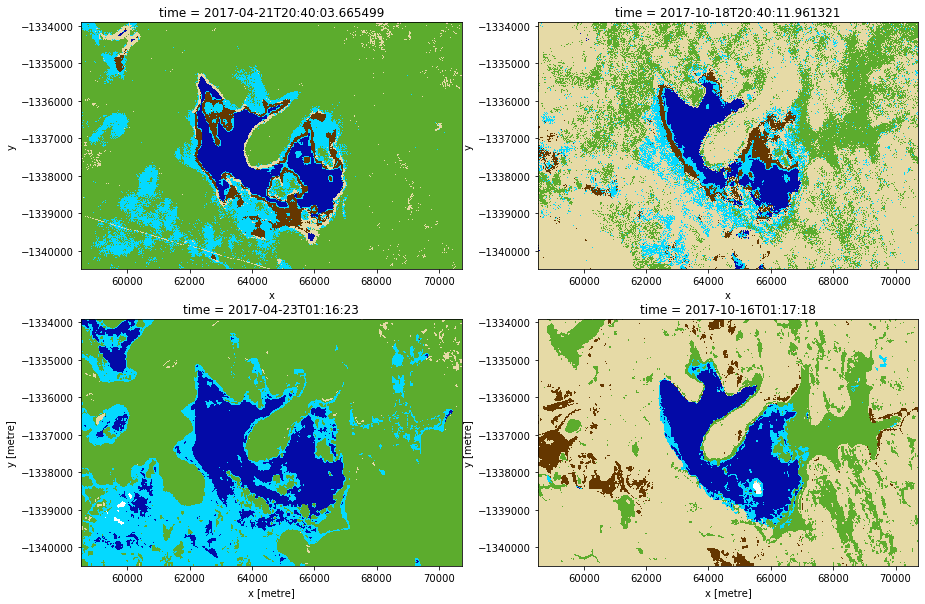

In [15]:
#plot the cover
fig,ax=plt.subplots(2,2,figsize=(15,10))
mapped_output.isel(time=35).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[0,0])
mapped_output.isel(time=57).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[0,1])
WIT_images.isel(time=5).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[1,0])
WIT_images.isel(time=14).plot(vmin=0,vmax=4.01,levels=6,colors=pal_opt,add_colorbar=False,ax=ax[1,1])

## Wetland dynamics: monthly composites & WIT-style stack plots

We can use the classification model to make monthly composites cover maps. This is done by taking the landcover maps for every observation in a month and then using the most common class predicted as the composite prediction for each pixel. The following code produces these composites and plots them beside a Sentinel-1 monthly composite, a false-colour (SWIR1-NIR-green) composite image and a composite WIT landcover map produced in the same way as the SAR classification composite.

In [61]:
import DEADataHandling
optical_ds = DEADataHandling.load_clearlandsat(dcO,query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 63 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [62]:
import fastmode

def modal_composite(data_array):
    return data_array.reduce(fastmode.mode_class,dim='time',num_classes = 5)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops

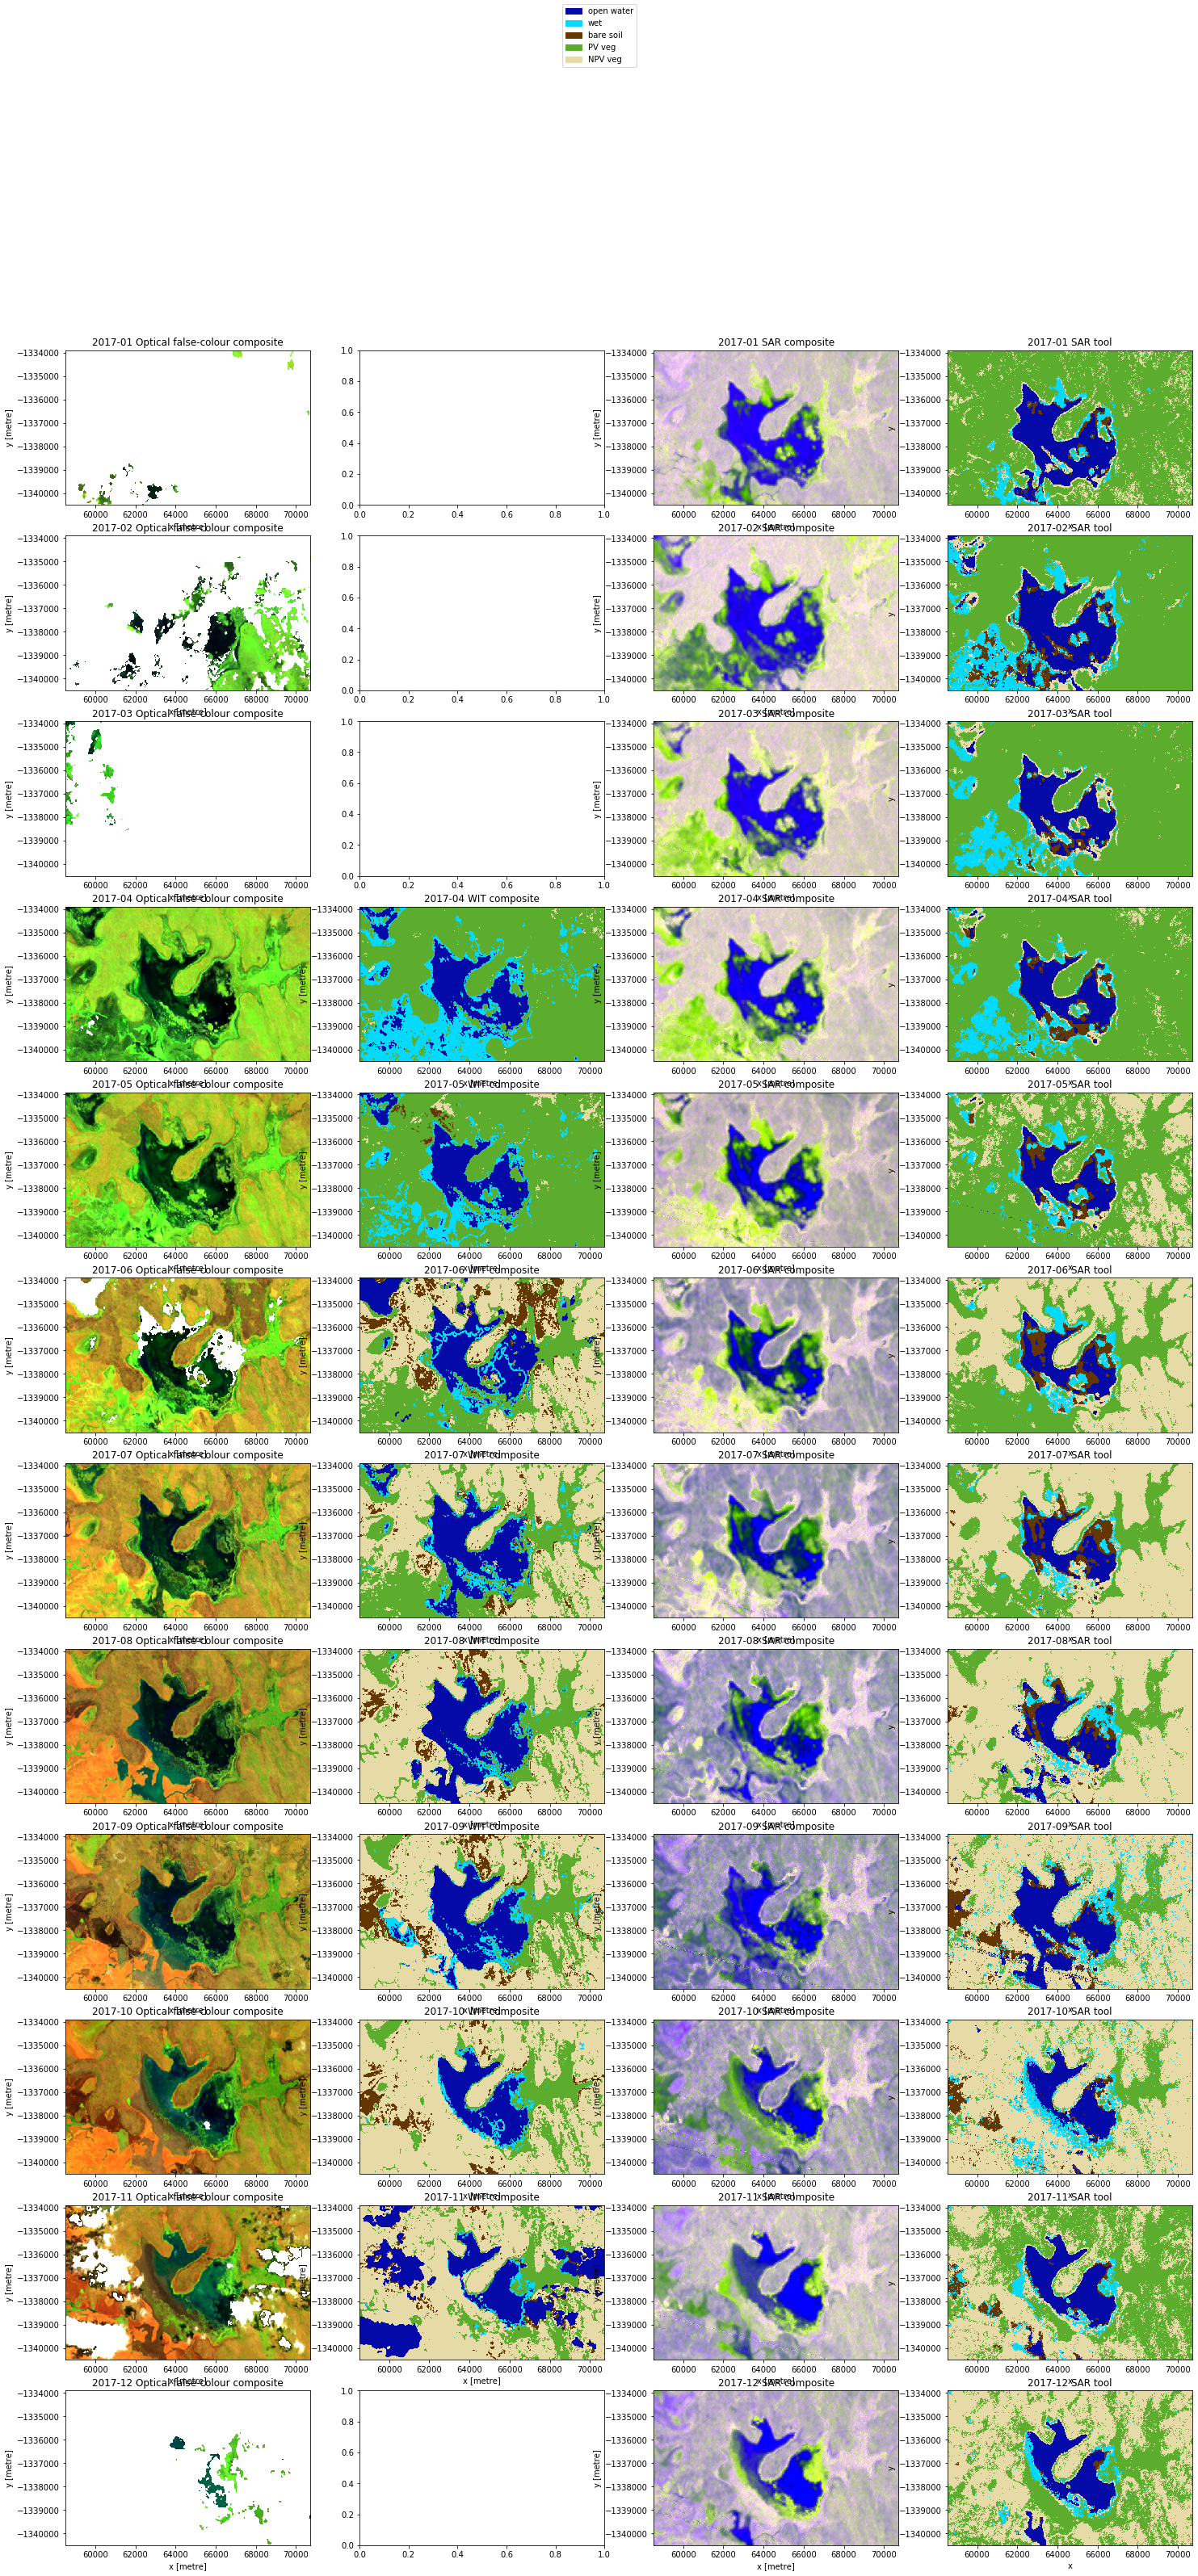

In [90]:
fig,ax = plt.subplots(12,4,figsize=(25,50))

for month in range(1,13):
    first = str(2017+(month-1)//12)+'-'+'{:02d}'.format((month-1)%12+1)+'-01'
    last = str(np.datetime64(str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01')-np.timedelta64(1,'D'))

    tslice = slice(first,last)
    
    #get optical false colour for the month
    opt_month = optical_ds.sel(time=tslice)
    if len(opt_month.green)>0:
        opt_mean = opt_month.mean(dim='time')
        DEAPlotting.rgb(opt_mean,bands=['swir1','nir','green'],ax=ax[month-1,0],size=None,robust=True)
        ax[month-1,0].title.set_text(first[:-3]+' Optical false-colour composite')

    
    #get the optical WIT maps for the month
    coverclasses = WIT_images.sel(time=tslice)
    
    if len(coverclasses)>0:
        comp = modal_composite(coverclasses)
        if comp is not None:
            comp.plot(ax=ax[month-1,1],vmin=0,vmax=4.01,levels=6,colors=pal_opt,label=None,add_colorbar=False)
            ax[month-1,1].title.set_text(first[:-3]+' WIT composite')
    
    #use this if you want to go back to per-scene preprocessing
    #sar_ds = load_cleaned_SAR(query)
    
    bulksar_ds = bulknormSAR.sel(time=tslice)
    
    predicted_sar = mapped_output.sel(time=tslice)
    
    monthly_classes = modal_composite(predicted_sar)
    
    compSAR = bulksar_ds.mean(dim='time')
    
    DEAPlotting.rgb(compSAR,bands=['vh','vv','vh_over_vv'],ax=ax[month-1,2],size=None,robust=True)
    ax[month-1,2].title.set_text(first[:-3]+' SAR composite')
    
    plt.sca(ax[month-1,3])
    
    monthly_classes.plot(add_colorbar=False,colors=pal_opt,vmin=0,vmax=4.01,levels=6)
    ax[month-1,3].title.set_text(first[:-3]+' SAR tool')


from matplotlib.patches import Patch
labels = ['open water', 'wet','bare soil', 'PV veg', 'NPV veg']
leg_elements = [Patch(facecolor = pal_opt[i], edgecolor = pal_opt[i], label = labels[i]) for i in range(len(labels))]

fig.legend(handles = leg_elements, loc = 'upper center')

It looks like the tree model does a pretty good job of picking up seasonal changes in land cover in this area, although depending on the exact realisation of the KMeans fits it can still have some trouble distinguishing between wet areas and bare soil during drier times of the year.

We can also produce handy summary images as stack plots in the style of the WIT summaries:

In [78]:
WIT_summary = wetlands_insight.WIT_array(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 31 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [91]:
#assigning our manual labels as an attribute to the Ktree model means it will automatically label its outputs with landcover classes
mapping = [2,3,2,0,0,0,3,1,4]
ktree_model.landcover_dict = mapping

t,ts = rg.tree_timeseries(bulknormSAR,ktree_model)

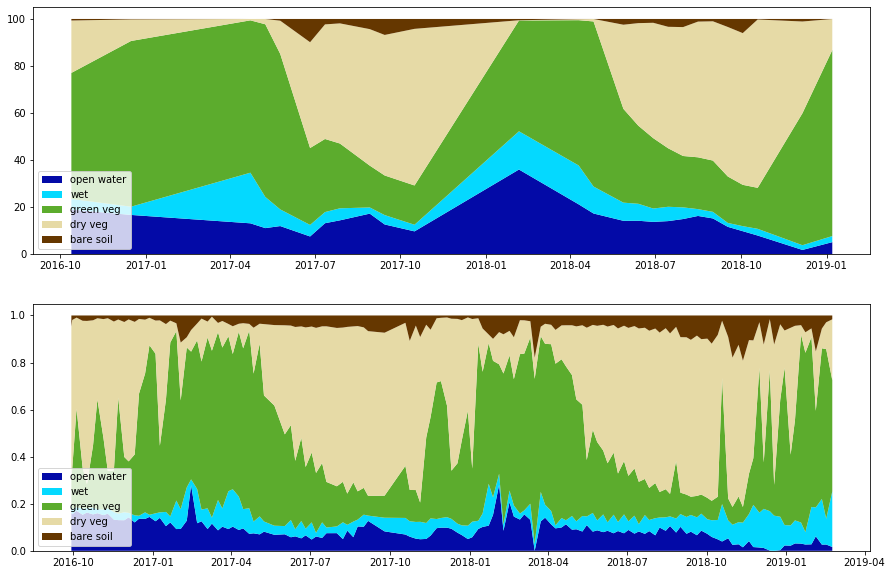

In [92]:
fig,ax = plt.subplots(2,1,figsize=(15,10))

#make sure the time periods line up for comparison
WIT_summary = WIT_summary.sel(time=slice(t[0],t[-1]))

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

plt.sca(ax[0])
plt.stackplot(WIT_summary.time.data,WIT_summary.to_array().data,labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal)

plt.legend(loc='lower left')

plt.sca(ax[1])
plt.stackplot(t.data,ts.transpose(),labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil'
                     ], colors=pal)

plt.legend(loc='lower left')

We see that the SARWIT model captures seasonal changes in landcover very well, especially changes in photosynthetic and nonphotosynthetic vegetation. We also see the power of the SAR signal to augment optical observations - there are many SAR observations during the period from November 2017 to March 2018, but only one optical observation which appears to occur during a short but severe flood. This gives the impression that there is a lot of wet ground during this whole period, but we see from the SAR summary that this is not the case.

Besides the aforementioned continuing difficulty of distinguishing bare soil from wet ground, the other issue with the SAR tool is a 'spikyness' in the photosynthetic vegetation signal - one observation may differ significantly from the two adjacent to it, especially during the transition from dry to wet seasons. This is possibly because the dataset of backscatter scenes combines observations from both Sentinel 1A and 1B, each with ascending and descending passes, and each of these types of scene may have slightly different signal characteristics. This warrants further investigation.

## Application at scale - Kakadu National Park

Unsupervised machine learning techniques do not have the same issue with separation of 'training' and 'test' dataset partitions as supervised techniques, as the algorithm is not provided with human input during the fitting phase and so there is no possibility of 'memorising' by overfitting the human responses for the training set. Despite this, we have manually labelled the output of our unsupervised algorithm, so it is important to check that these labels are robust under generalisation to a different dataset. For this purpose, we have taken a labelled clustering model trained by the procedure detailed above in the small Mamukala wetlands area, and used it to predict landcover labels for the entirety of Kakadu National Park. The script to perform this larger procedure yourself is stored in `bigpredict_kakadu.py`. It requires approx 250 GB of memory so you can only run it on an NCI node unless you modify the script to use Dask chunks or load the scenes for Kakadu for smaller time periods in sequence.

For demonstration purposes, the results from a run of this script are stored in `kakadu_sar.nc`. We will load them (using dask because the whole netCDF is 47 GB) and use them to generate some neat composites showing seasonal changes in Kakadu.

Be careful running the following cell too many times - there's a memory leak somewhere and I'm too lazy to find it.

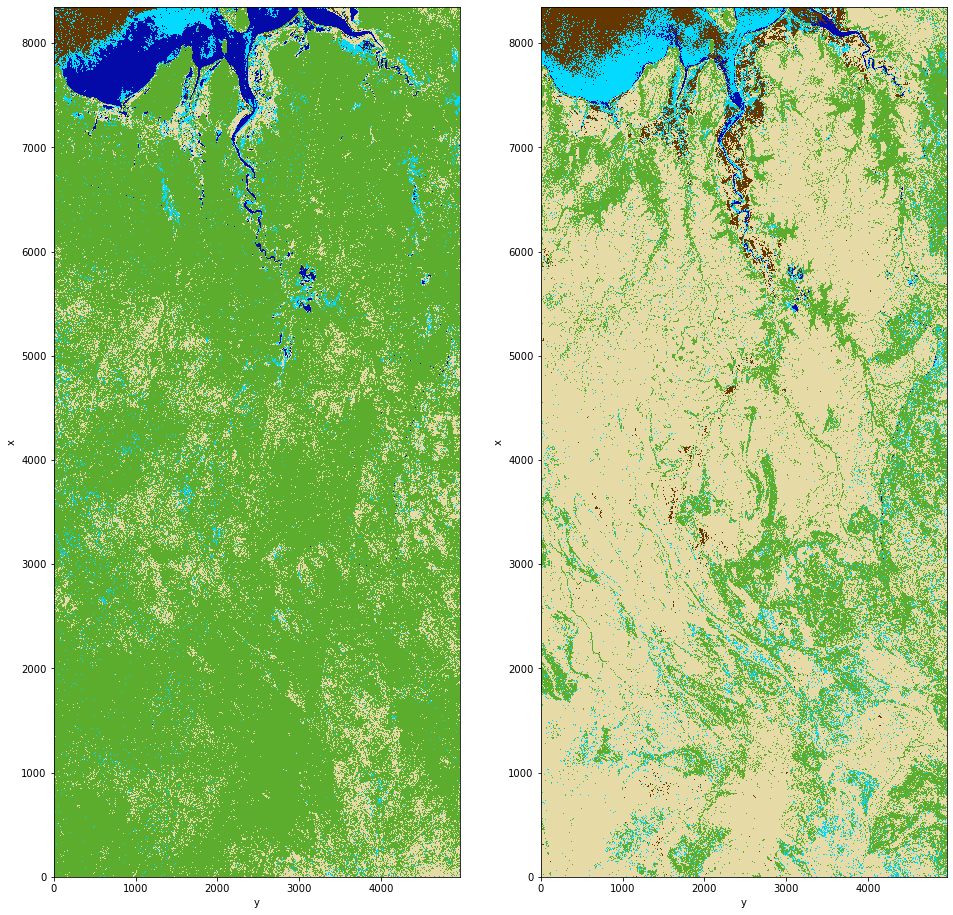

In [96]:
#the chunks kwarg automatically makes this a dask array
kakadu = xr.open_dataset('kakadu_sar1.nc',chunks={'time':1})

#give the numpy array a good ol compute - composites for january (wet) and july (dry) times of year
kakadu_jan_composite=kakadu.sel(time=slice('2017-01-01','2017-01-31')).compute()
kakadu_jul_composite=kakadu.sel(time=slice('2017-07-01','2017-07-31')).compute()

jan_comp_data=fastmode.mode_class(kakadu_jan_composite.cover_classes.data,num_classes=5)
jul_comp_data=fastmode.mode_class(kakadu_jul_composite.cover_classes.data,num_classes=5)

plottable1 = xr.DataArray(jan_comp_data,dims={'x':kakadu_jan_composite.x,'y':kakadu_jan_composite.y})
plottable2 = xr.DataArray(jul_comp_data,dims={'x':kakadu_jan_composite.x,'y':kakadu_jan_composite.y})

fig,ax = plt.subplots(1,2,figsize=(16,16))

plottable1.plot(vmin = 0, vmax = 4.01, levels=6, colors = pal, add_colorbar=False,ax=ax[0])
plottable2.plot(vmin = 0, vmax = 4.01, levels=6, colors = pal, add_colorbar=False,ax=ax[1])

Besides showing that the labels we chose earlier were quite robust (except the ocean probably shouldn't be brown muck), these composites give us some pretty nice insight into what happens in Kakadu during the wet and dry seasons. The January (left) composite shows the blooming of vegetation in the wet season, along with dozens of small intermittent waterbodies. The July composite shows an intricate pattern of drainage channels throughout the park - although these channels are occluded by the overwhelming green vegetation in January, they are outlined in July by the small areas of vegetation around them that remain green. The dry season composite also shows the drying of salt flats in the estuaries to the north.

The south end of the park contains many rocky outcrops. Our classification system has no way of detecting these, so they show up as anomalous 'wet' areas in the dry season - a failure of our labelling to account for land cover in non-wetland areas.